In [1]:
%matplotlib widget
import itertools
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy
import scipy.linalg
import scipy.signal
import os
# helpers.py is one level up in the directory structure so we need to tell Python were to find it
import sys
sys.path.append("../../")
import helpers
local_data_folder = os.path.join(helpers.dataset_folder, "week3", "collections")

%load_ext autoreload
%autoreload 2

# Searching image collections

In the previous excercises we have seen how an image can be inpainted without access to additional information. Yet, such an approach is limited in the variety of content it can produce. We can achieve much richer and more constent inpainting by copying existing image content from a similar image. For that we need a source of such images - an image collection. Furthermore, we need a fast and reliable way how to find good matches to our query image.

While we could potentially compare images pixel by pixel using the Sum of Squared Distances metric, a more efficient and often more robust approach is to utilize lower-dimensional image descriptors. One of the simplest choices is *GIST*.

The name *GIST* refers to the idea of extracting the gist of the image. GIST is a simple fixed-length vector of real numbers that summarizes distribution of contrast (or gradients in the image). It is built by averaging intensity of edges detected in several image regions, at several scales and several orientations.

In this assignment, we will compute GIST of an image and then use it to find similar images in a preprocessed image collection.

### GIST algorithm
There are several ways how to build a GIST descriptor. In this Assignment we apply a sequence of image convolutions (see Assignment 1.1) with differently oriented and sized Gabor filters. The results of each convolution are then split into a fixed-sized grid and averaged to obtain entries for the descriptor. Finally, a low resolution version of the image is appended to the final descriptor to encode the average color distribution.

## Exercise 7 (2 points)

The coefficients of the GIST descriptor are composed of image gradients detected at differet scales (representing range of spatial frequencies) and different orientations. 

We have previously used specialized filters to detect sharp edges (high frequency) with either horizontal or vertical orientation. 
Gabor filter (or Gabor patches) are a generalization of edge detection that is inspired by processing in human visual cortex.


<img src="gabor.png" alt="Gabor filter" style="width:20%">


A Gabor filter $f(x,y)$ is a product of a symmetrical bi-variate Gaussian filter
$$
g(x,y) = e^{-\frac{1}{2}\frac{x^2+y^2}{\sigma^2}}
$$
and a sinusoidal corrugation
$$
s(x,y) = \sin\left((x \cos(\alpha) - y \sin(\alpha)) \cdot f\right)
$$
with parameters
- $\sigma$ as a standard deviation controlling the width of the filter,
- $\alpha$ as an angle (in radians) controlling the orientation of the filter (and detected gradients)
- $f$ as a spatial frequency controling the sensitivity of the filter to sharp or smooth gradients.

Finally, the entire Gabor filter is
$$
f(x,y) = g(x,y) \cdot s(x,y) \cdot \left( \sum_{x,y} g(x,y) \right)^{-1}
$$
where the denominator on the right normalizes the sum of the Gaussian component to one. 

This normalization ensures that the response of the filter stays normalized regardless of the discretization to fixed-resolution pixel grid of size $s$.


### Task
Implement a method that returns `size` $\times$ `size` kernel of the Gabor filter as defined above.
The domain of the spatial variables $x$, $y$ covers the range $[-1, 1]$, that is $(x,y)\in[-1,1]\times[-1,1]$.

### Tips
Try how the filter changes for different choices of $\sigma$, $\alpha$ and $f$.

[[ 0  0]
 [ 1  0]
 [ 2  0]
 ...
 [32 34]
 [33 34]
 [34 34]]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
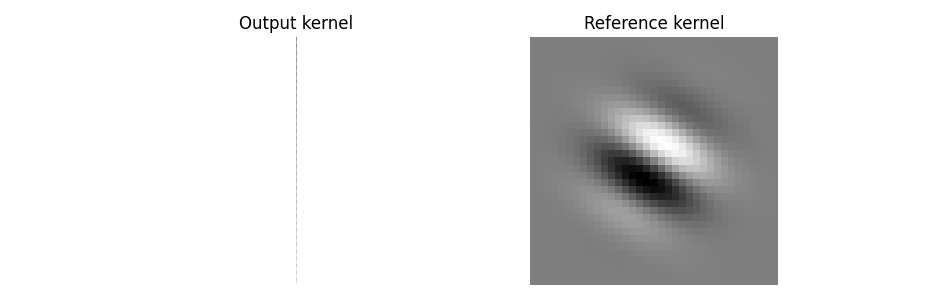

In [5]:
def build_gabor_filter(size, sigma, f, alpha):

    def gaussian_filter(x, y, sigma):
        return np.exp((x ** 2 + y ** 2)/(2 * sigma))
    
    def sinusoidal_corrugation(x, y, alpha, f):
        return np.sin((x*np.cos(alpha) - y*np.sin(alpha)) * f)


    gabor_filter = np.zeros((size, size))
    for row in range(size):
        for col in range(size):
            pass

            

    print(gabor_filter)
    return gabor_filter
    
gabor_filter = build_gabor_filter(35, 1.0/3.2, 8, np.radians(60))
    
helpers.show_images({
    'Output kernel': gabor_filter / gabor_filter.max() * 0.5 + 0.5,
    'Reference kernel': helpers.imread_normalized_float_grayscale(os.path.join(local_data_folder, 'gabor1.png')),
}, nrows=1, ncols=2)        

### Testing your solution of exercise 7
Make sure that your solution matches the references kernel.

## Exercise 8 (4 points)

The next step is to apply the filter $f(x,y)$ to a grayscale image $I(x,y)\in\mathcal{R}^{H\times W}$ using convolution. The Gabor filter response $r(x,y) = I(x,y) * f(x,y)$ has a sign that depends on the mutual orientation of the filter and the gradient. In this excercise the sign does not matter and therefore we return absolute value of the response $r_a(x,y) = |r(x,y)|$.

The filter response is expected to have the same resolution as the input image. However, we need the GIST descriptor to be relatively small. Therefore, we bin the response values into a `grid_size` $\times$ `grid_size` 2D histogram $H(i,j)$ where each bin contains mean of $r_a(x,y)$ for the pixels that are covered by that bin.

### Task
First, implement a method that for a given grayscale image returns an absolute Gabor filter response.
Second, implement a method that bins this response into a 2D histogram as defined above.

### Tips
- You can assume that the image size is divisible by the `grid_size`.
- You are allowed to use `scipy.signal.convolve2d(image, kernel, mode="same")`
- Exlore how the response of the filter changes for different parameters.

In [ ]:
def get_absolute_response(image, filter_size, sigma, f, alpha):
    # Use scipy.signal.fftconvolve for better performance.
    # YOUR CODE HERE
    raise NotImplementedError()
    # return abs_response, gabor_filter
    
def bin_values(vals, grid_size):
    # YOUR CODE HERE
    raise NotImplementedError()
    #return binned_values
    
image = helpers.imread_normalized_float_grayscale(os.path.join(local_data_folder, "grad_test.png"))

response, gabor_filter = get_absolute_response(image, 32, 1.0/3.2, 8, np.radians(45))
binned = bin_values(response, 4)
    
helpers.show_images({
    'Input Image': image,
    'Your Filter': gabor_filter / gabor_filter.max() * 0.5 + 0.5,
    'Your Response': response / response.max(),
    'Your Binned': plt.get_cmap('gray')(binned / binned.max())
}, nrows=1, ncols=4)

### Testing your solution of exercise 8
You can test your `bin_values(vals, grid_size)` function by creating a small and simple test image. Work out by hand what the binned image should look like and verify that your solution matches what you expect. The code below checks some basic properties such as the size of the returned image.

In [ ]:
image = helpers.imread_normalized_float_grayscale(os.path.join(local_data_folder, "grad_test.png"))
response, gabor_filter = get_absolute_response(image, 32, 1.0/3.2, 8, np.radians(45))
assert(gabor_filter.shape == (32, 32))
assert(response.shape == image.shape)


## Exercise 9 (5 points)
Finally, a *GIST* descriptor is formed by concatenation of flattened histograms $H_k$ for Gabor filters $g_k$ with different scales and orientations. Here is an example of a small filter bank with 3 different sizes $s$,= and 4 orientations $\alpha$:

<img src="gabors_4x3.png" alt="Gabor filters" style="width:60%" />


If we further consider a histogram size of $2\times2$, we obtain a GIST descriptor as a 1D vector with $3\times4\times2\times2 = 48$ values (for this particular choice of parameters). 
The GIST vector features one entire histogram row after another and this is repeated first for every orientation $\alpha$ and then for every scale $s$, so that the order is:
$$
[s_0,\alpha_0,y_0,x_0], [s_0,\alpha_0,y_0,x_1],\cdots[s_0,\alpha_0,y_1,x_0],\cdots[s_0,\alpha_1,y_0,x_0],\cdots[s_1,\alpha_0,y_0,x_0],\cdots[s_S,\alpha_A,y_Y,x_X].
$$

The GIST alone only describes the distribution of gradients in the image. To make it more powerfull, we append one more histogram describing the distribution of the colors in the image similarly as shown for the collection-based inpainting in the lecture.
This color histogram is built the same way as previously but instead of the filter response it averages the RGB value of the image. When appeneded at the end of the descriptor, it adds another `grid_size` $\times$ `grid_size` $\times 3$ values that correspond to a flattened 2D color histogram with an order:

$$
[y_0,x_0,R],[y_0,x_0,G],[y_0,x_0,B],\cdots[y_0,x_1,R],[y_0,x_1,G],[y_0,x_1,B],\cdots[y_1,x_0,R],[y_1,x_0,G],[y_0,x_1,B],\cdots
$$

The final descriptor for this assignment is then defined as
$\mathbf{d} = [\textrm{GIST} \cdot w_{grad}, H_{RGB}]$
where $w_{grad}$ is additional weight scalar that scales the contribution of the gradients.

### Task
Implement a method that computes a full descriptor of given RGB image including the RGB appendix. 
Cover all combinations of sizes $s$ and orientations $\alpha$.

### Tips
- The histogram method developed in previous excercise can be easily adapted to compute the RGB histogram.
- Visualize the individual filters and their responses in a similar grid as shown in the exercise to better understand what each filter scale and orientation does.

In [ ]:
def image_rgb_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def build_gist_descriptor(image, filte_sizes, alphas, sigma, f, grid_size, grad_weight):
    # Use image_rgb_to_grayscale() to convert the RGB image to grayscale.
    # YOUR CODE HERE
    raise NotImplementedError()
    # return descriptor
    
image = helpers.imread_normalized_float(os.path.join(local_data_folder, "spatenv/opencountry_land228.jpg"))

    
filter_sizes = np.array([9,17,33,65])
alphas = np.radians(np.arange(6, dtype=float)/6*180)
sigma = 1.0 / 3.2
f = 8
grid_size = 4
grad_weight = 20
descriptor = build_gist_descriptor(image, filter_sizes, alphas, sigma, f, grid_size, grad_weight)


# Visualize.
dsize = grid_size**2
s_maxs = np.array([descriptor[i*(dsize*len(alphas)):(i+1)*(dsize*len(alphas))].max() for i in range(len(filter_sizes))])
panels = {}
for i, (s, a) in enumerate(itertools.product(filter_sizes, alphas)):
    d = descriptor[i*dsize:(i+1)*dsize].reshape(grid_size, grid_size)
    panels[f's={s} a={np.degrees(a):.0f}'] = plt.get_cmap('viridis')(d / s_maxs[filter_sizes==s])
panels['RGB'] = descriptor[-(dsize*3):].reshape(grid_size,grid_size,3)
skeys = ['s=9 a=0','s=17 a=60', 's=33 a=90', 's=65 a=120', 'RGB']
panels = {f'Your {k}': panels[k] for k in skeys}
panels.update({f'Refer. {k}': helpers.imread_normalized_float(os.path.join(local_data_folder, f"codes/{k.replace('=', '_')}.png")) for k in skeys})
helpers.show_images(panels, nrows=2, ncols=len(skeys), col_height=2.2)

### Testing your solution of exercise 3
Compare your solutions to the provided reference.

## Exercise 10 (4 points)

We can now use the resulting descriptor to quickly find a set of $k$ most similar images in potentially large image collection which would take a long time to compare pixel-by-pixel. 

In this exercise we will find the most similar image by minimizing the L2 distance between the query image descriptor $\mathbf{d}$ and the collection image descriptors $\mathbf{d}_i$ such that the index of the most similar image $j$ is
$$
j = \arg\min_{i} ||\mathbf{d} - \mathbf{d}_i||^2_2.
$$

This is useful for exploring large image collections where a search engine can suggest other images similar to the one we are looking at. It can also be used for a coarse categorization of images (coast, mountains, road, city,...) and in the lecture we have seen that a similar image can be used for image inpainting. 

Note, that for an effective implementation, we must ignore the pixels that are marked as invalid in a provided inpainting mask $M$. That means that every convolution has to carefully avoid sampling the invalid pixels which results in a more complex and slow implementation This is why in this exercise we simulate similar effect by modifying the query image.

### Task

Implement a method that replaces marked pixels in a given RGB image $\mathbf{I} \in \mathcal{R}^{H \times W \times 3}$ with pixels from the most similar image in a provided image collection. 
The marked pixels are encoded by zeros in the provided mask $M \in [0,1]^{H \times W}$.
Find the most similar image by minimizing the L2 descriptor norm as shown above.
To compute the query image descriptor, use a modified query image generated from the input image by replacing the invalid pixels ($M = 0$) by a uniform gray color ($[0.5, 0.5, 0.5]$).
Return the modified query image, the most similar collection image and the inpainted image.


### Tips
- The descriptors for all images in the dataset are provided and do not need to be recomputed.
- Visualize several of the most similar and also several of the least similar images. 
- Test the query with your own image. Note that the metric is only effective if the collection contains a very close match of the query image. In practice, that means that collections of milions of images are needed. In this example we only use a very small collection of pre-selected image samples.

Images courtesy of [8 Scene Categories Dataset](http://people.csail.mit.edu/torralba/code/spatialenvelope/)

In [ ]:
def inpaint_image(image, mask, dataset_descriptors, dataset_files, 
                 filter_sizes, alphas, sigma, f, grid_sizes, grad_weight):
    # Use helpers.imread_normalized_float(dataset_files[i]) to read an image i
    # YOUR CODE HERE
    raise NotImplementedError()
    #return query_image, nearest_image, inpainted_image 

filter_sizes = np.array([9,17,33,65])
alphas = np.radians(np.arange(6, dtype=float)/6*180)
sigma = 1.0 / 3.2
f = 8
grid_size = 4
grad_weight = 20

dataset_files = sorted(helpers.list_files_in_folder(os.path.join(local_data_folder, "spatenv"), filter="*.jpg"))
dataset_descriptors = np.load(os.path.join(local_data_folder, 'spatenv_descs.npy'))
image = helpers.imread_normalized_float(os.path.join(local_data_folder, "opencountry_land493.jpg"))
mask = np.zeros(image.shape[:2])
mask[:image.shape[0]//2] = 1

query, nearest, inpainted = inpaint_image(image.copy(), mask, dataset_descriptors, dataset_files,
                                        filter_sizes, alphas, sigma, f, grid_size, grad_weight)
                                        
helpers.show_images({
    'Your Input': image,
    'Your Query': query,
    'Your Nearest': nearest,
    'Your Result': inpainted
}, nrows=1, ncols=4, col_height=3)

### Testing your solution of exercise 10
Have a look at the set of images in the data set (`datasets/week3/collections/spatenv/` folder). Is the image picked by your algorithm close to the query image (compared to the other images in the data set)? Try different query images and check if this is still the case.

The code below checks some basic properties such as the size of the returned images.

In [ ]:
filter_sizes = np.array([9,17,33,65])
alphas = np.radians(np.arange(6, dtype=float)/6*180)
sigma = 1.0 / 3.2
f = 8
grid_size = 4
grad_weight = 20

dataset_files = sorted(helpers.list_files_in_folder(os.path.join(local_data_folder, "spatenv"), filter="*.jpg"))
dataset_descriptors = np.load(os.path.join(local_data_folder, 'spatenv_descs.npy'))
image = helpers.imread_normalized_float(os.path.join(local_data_folder, "opencountry_land493.jpg"))
mask = np.zeros(image.shape[:2])
mask[:image.shape[0]//2] = 1

query, nearest, inpainted = inpaint_image(image.copy(), mask, dataset_descriptors, dataset_files,
                                        filter_sizes, alphas, sigma, f, grid_size, grad_weight)
assert(query.shape == image.shape)
assert(nearest.shape == image.shape)
assert(inpainted.shape == image.shape)
